In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import shapiro, f_oneway, friedmanchisquare, ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

SCORES_DIR = "../results/cv_scores"  # notebook en src/results/

all_scores_p1 = {
    "LogReg": np.load(os.path.join(SCORES_DIR, "probl1_logreg_scores.npy")),
    "RandomForest": np.load(os.path.join(SCORES_DIR, "probl1_randomforest_scores.npy")),
    "XGBoost": np.load(os.path.join(SCORES_DIR, "probl1_xgboost_scores.npy")),
    "NeuralNet_MLP": np.load(os.path.join(SCORES_DIR, "probl1_mlp_scores.npy")),
}

# --- SVM (si existe) ---
svm_path = os.path.join(SCORES_DIR, "probl1_svm_scores.npy")
if os.path.exists(svm_path):
    all_scores_p1["SVM"] = np.load(svm_path)
    print("✅ SVM incluido:", svm_path)
else:
    print("⚠️ No encontré:", svm_path, "| si tu archivo se llama distinto, dime el nombre exacto.")

for k, v in all_scores_p1.items():
    print(k, v.shape, "mean=", v.mean(), "std=", v.std())


✅ SVM incluido: ../results/cv_scores/probl1_svm_scores.npy
LogReg (30,) mean= 0.8178798771412722 std= 0.004676641228199858
RandomForest (30,) mean= 0.7204133604346654 std= 0.007214729953753129
XGBoost (30,) mean= 0.7778955844104801 std= 0.00625077321370059
NeuralNet_MLP (30,) mean= 0.8609099962360415 std= 0.007919717792829585
SVM (30,) mean= 0.8738972456385474 std= 0.0036913799766126296


In [14]:
summary_rows = []
for model, arr in all_scores_p1.items():
    summary_rows.append({
        "model": model,
        "n": len(arr),
        "mean": float(arr.mean()),
        "std": float(arr.std()),
        "min": float(arr.min()),
        "max": float(arr.max())
    })

summary_df_p1 = pd.DataFrame(summary_rows).sort_values("mean", ascending=False)
summary_df_p1


,model,n,mean,std,min,max
4,SVM,30,0.873897,0.003691,0.866779,0.880890
3,NeuralNet_MLP,30,0.860910,0.007920,0.842838,0.877588
0,LogReg,30,0.817880,0.004677,0.809064,0.825342
2,XGBoost,30,0.777896,0.006251,0.767688,0.797482
1,RandomForest,30,0.720413,0.007215,0.704613,0.733361


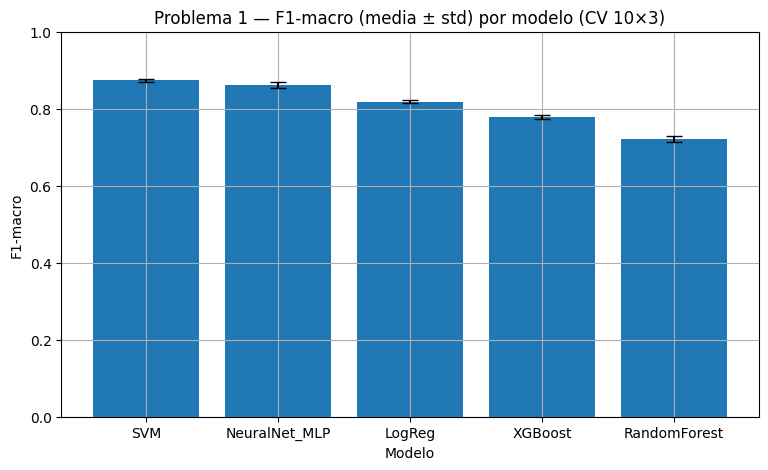

In [15]:
models = summary_df_p1["model"].tolist()
means = summary_df_p1["mean"].to_numpy()
stds  = summary_df_p1["std"].to_numpy()

plt.figure()
plt.bar(models, means, yerr=stds, capsize=6)
plt.ylim(0, 1.0)
plt.title("Problema 1 — F1-macro (media ± std) por modelo (CV 10×3)")
plt.ylabel("F1-macro")
plt.xlabel("Modelo")
plt.show()


/tmp/ipykernel_74103/725236316.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=models, showmeans=True)


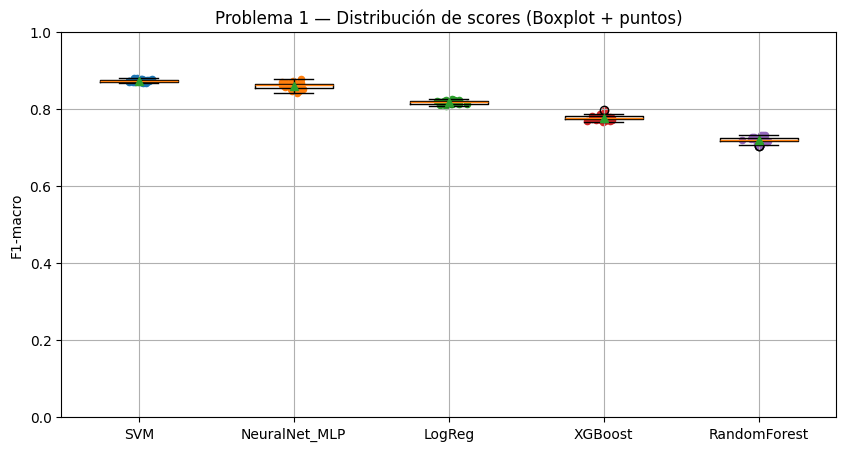

In [16]:
data = [all_scores_p1[m] for m in models]

plt.figure(figsize=(10, 5))
plt.boxplot(data, labels=models, showmeans=True)

for i, m in enumerate(models, start=1):
    y = all_scores_p1[m]
    x = np.random.normal(loc=i, scale=0.04, size=len(y))
    plt.scatter(x, y, s=20)

plt.ylim(0, 1.0)
plt.title("Problema 1 — Distribución de scores (Boxplot + puntos)")
plt.ylabel("F1-macro")
plt.show()


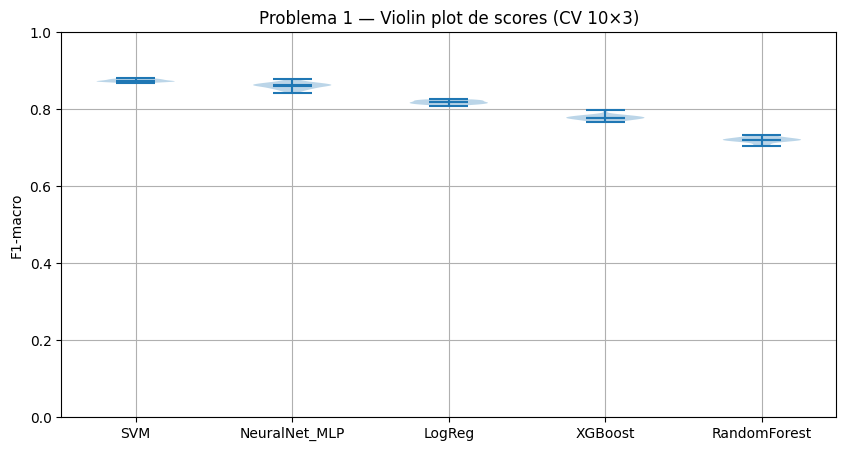

In [17]:
plt.figure(figsize=(10, 5))
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(ticks=range(1, len(models)+1), labels=models)
plt.ylim(0, 1.0)
plt.title("Problema 1 — Violin plot de scores (CV 10×3)")
plt.ylabel("F1-macro")
plt.show()


In [18]:
alpha = 0.05
normality_rows = []
all_normal = True

for model, arr in all_scores_p1.items():
    stat, p = shapiro(arr)
    is_normal = p > alpha
    normality_rows.append({
        "model": model,
        "W": float(stat),
        "p_value": float(p),
        "normal(alpha=0.05)": bool(is_normal)
    })
    if not is_normal:
        all_normal = False

normality_df_p1 = pd.DataFrame(normality_rows).sort_values("p_value", ascending=True)
normality_df_p1, all_normal


(           model         W   p_value  normal(alpha=0.05)
 2        XGBoost  0.953861  0.214269                True
 1   RandomForest  0.955731  0.240048                True
 0         LogReg  0.955847  0.241739                True
 4            SVM  0.973408  0.635979                True
 3  NeuralNet_MLP  0.979267  0.805731                True,
 True)

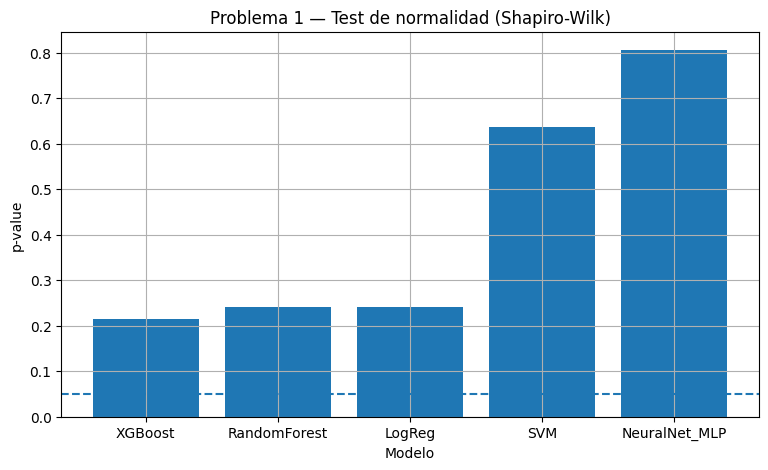

In [19]:
plt.figure()
plt.bar(normality_df_p1["model"], normality_df_p1["p_value"])
plt.axhline(0.05, linestyle="--")
plt.title("Problema 1 — Test de normalidad (Shapiro-Wilk)")
plt.ylabel("p-value")
plt.xlabel("Modelo")
plt.show()


In [20]:
score_lists = [all_scores_p1[m] for m in models]

if all_normal:
    stat, p_global = f_oneway(*score_lists)
    global_test = "ANOVA"
else:
    stat, p_global = friedmanchisquare(*score_lists)
    global_test = "Friedman"

print("Test global usado:", global_test)
print("stat =", stat)
print("p-value =", p_global)


Test global usado: ANOVA
stat = 3023.590026895293
p-value = 1.577087678875093e-138


In [21]:
best_model = summary_df_p1.iloc[0]["model"]
best_scores = all_scores_p1[best_model]

pair_rows = []
pvals = []

for m in models:
    if m == best_model:
        continue

    if all_normal:
        stat, p = ttest_rel(best_scores, all_scores_p1[m])
        test_name = "paired t-test"
    else:
        stat, p = wilcoxon(best_scores, all_scores_p1[m])
        test_name = "Wilcoxon"

    pair_rows.append({
        "best": best_model,
        "vs": m,
        "test": test_name,
        "p_value": float(p),
        "best_mean": best_scores.mean(),
        "vs_mean": all_scores_p1[m].mean()
    })
    pvals.append(p)

reject, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method="holm")

for i, row in enumerate(pair_rows):
    row["p_value_holm"] = float(pvals_corr[i])
    row["significant(alpha=0.05)"] = bool(reject[i])

pairwise_df_p1 = pd.DataFrame(pair_rows).sort_values("p_value_holm")
pairwise_df_p1



,best,vs,test,p_value,best_mean,vs_mean,p_value_holm,significant(alpha=0.05)
3,SVM,RandomForest,paired t-test,1.915985e-41,0.873897,0.720413,7.663938e-41,True
2,SVM,XGBoost,paired t-test,1.043527e-37,0.873897,0.777896,3.130582e-37,True
1,SVM,LogReg,paired t-test,5.349500e-33,0.873897,0.817880,1.069900e-32,True
0,SVM,NeuralNet_MLP,paired t-test,6.105400e-10,0.873897,0.860910,6.105400e-10,True


In [23]:
print("==== CONCLUSIÓN (Problema 1) ====")
display(summary_df_p1)
display(normality_df_p1)

print(f"Test global: {global_test} | p = {p_global:.6f}")

if p_global < 0.05:
    print(f"Modelo con mejor media: {best_model}")
    display(pairwise_df_p1)
else:
    print("No hay diferencias globales significativas.")


==== CONCLUSIÓN (Problema 1) ====


,model,n,mean,std,min,max
4,SVM,30,0.873897,0.003691,0.866779,0.880890
3,NeuralNet_MLP,30,0.860910,0.007920,0.842838,0.877588
0,LogReg,30,0.817880,0.004677,0.809064,0.825342
2,XGBoost,30,0.777896,0.006251,0.767688,0.797482
1,RandomForest,30,0.720413,0.007215,0.704613,0.733361


,model,W,p_value,normal(alpha=0.05)
2,XGBoost,0.953861,0.214269,True
1,RandomForest,0.955731,0.240048,True
0,LogReg,0.955847,0.241739,True
4,SVM,0.973408,0.635979,True
3,NeuralNet_MLP,0.979267,0.805731,True


Test global: ANOVA | p = 0.000000
Modelo con mejor media: SVM


,best,vs,test,p_value,best_mean,vs_mean,p_value_holm,significant(alpha=0.05)
3,SVM,RandomForest,paired t-test,1.915985e-41,0.873897,0.720413,7.663938e-41,True
2,SVM,XGBoost,paired t-test,1.043527e-37,0.873897,0.777896,3.130582e-37,True
1,SVM,LogReg,paired t-test,5.349500e-33,0.873897,0.817880,1.069900e-32,True
0,SVM,NeuralNet_MLP,paired t-test,6.105400e-10,0.873897,0.860910,6.105400e-10,True
